In [1]:
import numpy as np
import pandas as pd 

from sklearn.datasets import load_boston
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LogisticRegression, LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.utils import check_array, check_X_y
from sklearn.utils.validation import FLOAT_DTYPES, check_random_state, check_is_fitted

from sklego.common import as_list
from sklego.pipeline import DebugPipeline
from sklego.preprocessing import InformationFilter


def scaler_(vec, unto):
    return vec.dot(unto)/unto.dot(unto)


def project_(vec, unto):
    return scaler_(vec, unto) * unto


def orthogonal_(arr, away):
    return arr - project_(arr, away)

In [2]:
print(load_boston()['DESCR'][:1230])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [3]:
X, y = load_boston(return_X_y=True)
df = pd.DataFrame(X, columns=['crim','zn','indus','chas','nox','rm','age','dis','rad','tax','ptratio','b','lstat'])
df.head(3)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03


In [30]:
sensitive_var = ["lstat", "b"]

In [31]:
from scipy.spatial.distance import cosine
import matplotlib.pylab as plt

In [32]:
pipe = Pipeline([
    ("scale", StandardScaler()),
    ("model", LinearRegression())
])

pipe_filter = Pipeline([
    ("filter", InformationFilter(sensitive_var)),
    ("scale", StandardScaler()),
    ("model", LinearRegression())
])

pred_before = pipe.fit(df, y).predict(df)
pred_after = pipe_filter.fit(df, y).predict(df)

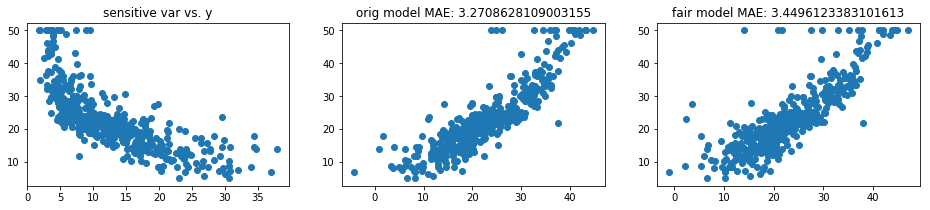

In [33]:
plt.figure(figsize=(16,3))
plt.subplot(131)
plt.scatter(df[sensitive_var[0]], y)
plt.title("sensitive var vs. y")
plt.subplot(132)
plt.scatter(pred_before, y)
plt.title(f"orig model MAE: {np.abs(pred_before - y).mean()}")
plt.subplot(133)
plt.scatter(pred_after, y)
plt.title(f"fair model MAE: {np.abs(pred_after - y).mean()}");

In [34]:
def bootstrapper(mod, var="b", n=250, k=25):
    selector = df[var] > np.quantile(df[var], 0.5)
    res = []
    for i in range(n):
        s1 = mod.predict(df[selector].sample(k))
        s2 = mod.predict(df[~selector].sample(k))
        res.append(s1.mean() - s2.mean())
    return res, np.mean(res)

def bootstrap_plot(mod_a, mod_b, sens_var, n=2000, k=50):
    samples, avg1 = bootstrapper(mod_a, var=sens_var, n=n, k=k)
    height, bins, _ = plt.hist(samples, density=True, alpha=0.6, bins=30)
    plt.vlines(avg1, 0, height.max());
    samples, avg2 = bootstrapper(mod_b, var=sens_var, n=n, k=k)
    height, bins, _ = plt.hist(samples, density=True, alpha=0.6, bins=30)
    plt.vlines(avg2, 0, height.max())
    print(f"difference = {avg2 - avg1} -> {(avg2 - avg1)/np.abs(avg1)}");

In [ ]:
bootstrap_plot(pipe, pipe_filter, sens_var="lstat")

In [ ]:
bootstrap_plot(pipe, pipe_filter, sens_var="b")